<img src="../part_of_cover_bakker_post.png" width="800px">

The Python code provided below is from <br>
**Analytical Groundwater Modeling: Theory and Applications Using Python** <br>
by *Mark Bakker and Vincent Post* <br>
ISBN 9781138029392

The book is published by CRC press and is available [here](https://www.routledge.com/Analytical-Groundwater-Modeling-Theory-and-Applications-using-Python/Bakker-Post/p/book/9781138029392).

This Notebook is provided under the [MIT license](https://github.com/pythongroundwaterbook/analytic_gw_book/blob/main/LICENSE). 

<p>© 2022 Mark Bakker and Vincent Post</p>

# Steady one-dimensional flow with variable saturated thickness

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 3) # set default figure size
plt.rcParams["contour.negative_linestyle"] = 'solid' # set default line style
plt.rcParams["figure.autolayout"] = True # same at tight_layout after every plot

## Areal recharge between an impermeable boundary and a river

<img src="figs/fig3.1.png" width=400>

In [2]:
# parameters
L = 1000 # aquifer length, m
H = 10 # aquifer thickness, m
zb = -5 # aquifer bottom, m
k = 10 # hydraulic conductivity, m/d
n = 0.3 # porosity, -
hL = 4 # specified head at the right boundary, m
N = 0.001  # areal recharge, m/d

In [3]:
# solution
phiL = 0.5 * k * (hL - zb) ** 2
x = np.linspace(0, L, 100)
phi = -N / 2 * (x ** 2 - L ** 2) + phiL
h = zb + np.sqrt(2 * phi / k)
happrox = -N / (2 * k * H) * (x ** 2 - L ** 2) + hL
Qx = N * x

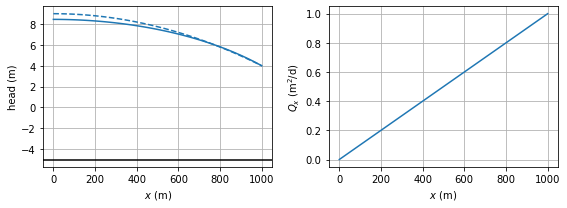

In [4]:
# basic plot
plt.subplot(121)
plt.plot(x, h)
plt.plot(x, happrox, 'C0--')
plt.axhline(zb, color='k')
plt.grid()
plt.xlabel('$x$ (m)')
plt.ylabel('head (m)')
plt.subplot(122)
plt.plot(x, Qx)
plt.grid()
plt.xlabel('$x$ (m)')
plt.ylabel('$Q_x$ (m$^2$/d)');

In [5]:
print(f'flux to left river: {-Qx[0]:.3f} m^2/d')
print(f'flux to right river: {Qx[-1]:.3f} m^2/d')

flux to left river: -0.000 m^2/d
flux to right river: 1.000 m^2/d


In [6]:
# solution
psi = np.zeros((2, len(x)))
psi[1] = -Qx
xg = np.zeros_like(psi)
xg[:] = x
zg = np.zeros_like(psi)
zg[0] = zb
zg[1] = h

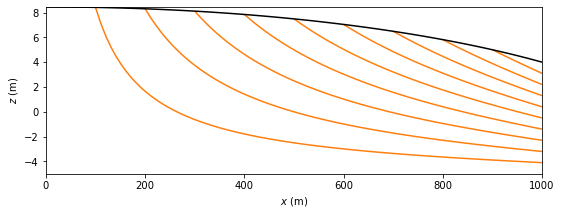

In [7]:
# basic streamline plot
plt.subplot(111, aspect=25)
plt.contour(xg, zg, psi, 10, colors='C1', linestyles='-')
plt.plot(x, h, 'k')
plt.xlabel('$x$ (m)')
plt.ylabel('$z$ (m)');

In [8]:
# solution
def integral(x):
    a = 2 * phiL / N + L ** 2
    return np.sqrt(a - x ** 2) - np.sqrt(a) * \
           np.arctanh(np.sqrt(a - x ** 2) / np.sqrt(a))

def traveltime(x):
    return n / np.sqrt(N * k) * (integral(L) - integral(x))

x = np.linspace(10, L, 100)
trtime = traveltime(x)

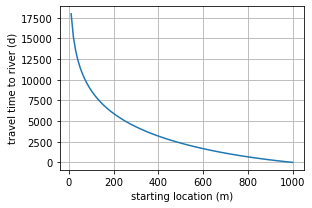

In [9]:
# basic travel time plot
plt.subplot(121)
plt.plot(x, trtime)
plt.xlabel('starting location (m)')
plt.ylabel('travel time to river (d)')
plt.grid();

## Flow over a step in the aquifer base 

<img src="figs/fig3.2.png" width=400>

In [10]:
# parameters
k = 10 # hydraulic conductivity, m/d
z0 = 0 # base elevation left section, m
z1 = -4 # base elevation right section, m
L0 = 500 # length of left section, m
L1 = 500 # length of right section, m
L = L0 + L1 # total distance between rivers, m
h0 = 10 # specified head at the left boundary, m
hL = 0 # specified head at the right boundary, m

In [11]:
# solution
phi0 = 0.5 * k * (h0 - z0)**2
phiL = 0.5 * k * (hL - z1)**2

def hmin(U, L0=L0, z0=z0, phi0=phi0):
    return np.sqrt(2 * (-U * L0 + phi0) / k) + z0

def hplus(U, L1=L1, z1=z1, phiL=phiL):
    return np.sqrt(2 * (U * L1 + phiL) / k) + z1

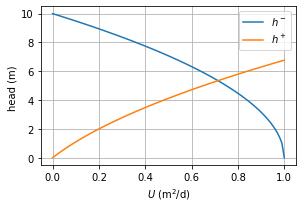

In [12]:
# basic plot two conditions
U = np.linspace(0, 1, 100)
plt.subplot(121)
plt.plot(U, hmin(U), label='$h^-$')
plt.plot(U, hplus(U), label='$h^+$')
plt.legend()
plt.xlabel('$U$ (m$^2$/d)')
plt.ylabel('head (m) ')
plt.grid();

In [13]:
from scipy.optimize import fsolve

def hdiff(U):
    return hmin(U) - hplus(U)

U = fsolve(hdiff, 0.7)[0]  # first value of array returned by fsolve
print(f'U: {U:0.4f} m^2/d')

ModuleNotFoundError: No module named 'scipy'

In [14]:
# solution
x = np.hstack((np.linspace(0, L0 - 1e-6, 100), np.linspace(L0 + 1e-6, L, 100)))
phi = np.empty_like(x)
phi[x < L0] = -U * x[x < L0] + phi0
phi[x >= L0] = -U * (x[x >= L0] - L) + phiL
h = np.zeros_like(phi)
h[x < L0] = np.sqrt(2 * phi[x < L0] / k) + z0
h[x >= L0] = np.sqrt(2 * phi[x >= L0] / k) + z1
#
psi = np.zeros((2, len(x)))
psi[1] = -U
xg = np.zeros_like(psi)
xg[:] = x
zg = np.zeros_like(xg)
zg[0, :100] = z0
zg[0, 100:] = z1
zg[1] = h

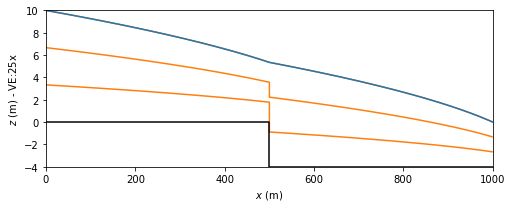

In [15]:
# basic streamline plot
plt.subplot(111, aspect=25)
plt.contour(xg, zg, psi, np.linspace(-U, 0, 4), colors='C1', linestyles='-')
plt.plot(x, h, 'C0')
plt.plot(x, zg[0], 'k')
plt.xlabel('$x$ (m)')
plt.ylabel(f'$z$ (m) - VE:25x');

## Combined confined/unconfined flow with areal recharge

<img src="figs/fig3.3.png" width=400>

In [16]:
# parameters
L = 1000 # aquifer length, m
H = 10 # aquifer thickness, m
zb = -5 # aquifer base, m
k = 10 # hydraulic conductivity, m/d
h0 = 6 # specified head at the left boundary, m
hL = 4 # specified head at the right boundary, m
N = 0.001  # areal recharge, m/d

In [17]:
# solution
C = -0.5 * k * H**2 - k * H * zb
phi0 = k * H * h0 + C
phi1 = 0.5 * k * (hL - zb)**2
phit = 0.5 * k * H**2  # transition potential
x = np.linspace(0, L, 400)
phi = -N / 2 * (x ** 2 - L * x) + (phi1 - phi0) * x / L + phi0
h = np.zeros_like(phi)
h[phi >= phit] = (phi[phi > phit] - C) / (k * H)
h[phi <= phit] = zb + np.sqrt(2 * phi[phi <= phit] / k)
Qx = N * (x - L / 2) - (phi1 - phi0) / L 
happrox = -N / (2 * k * H) * (x ** 2 - L * x) + (hL - h0) * x / L + h0
Qxapprox = N * (x - L / 2) - k * H * (hL - h0) / L 

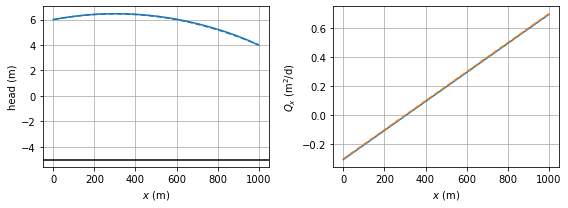

In [18]:
# basic plot
plt.subplot(121)
plt.plot(x, h)
plt.plot(x, happrox, 'C0--')
plt.axhline(zb, color='k')
plt.grid()
plt.xlabel('$x$ (m)')
plt.ylabel('head (m)')
plt.subplot(122)
plt.plot(x, Qx)
plt.plot(x, Qxapprox, 'C1--')
plt.grid()
plt.xlabel('$x$ (m)')
plt.ylabel('$Q_x$ (m$^2$/d)');

In [19]:
print(f'flux to left river: {-Qx[0]:.3f} m^2/d')
print(f'flux to right river: {Qx[-1]:.3f} m^2/d')

flux to left river: 0.305 m^2/d
flux to right river: 0.695 m^2/d


In [20]:
# solution
psi = np.zeros((2, len(x)))
psi[1] = -Qx
xg = np.zeros_like(psi)
xg[:] = x
zg = np.zeros_like(psi)
zg[0] = zb
zg[1] = H + zb
zg[1, h < H + zb] = h[h < H + zb]

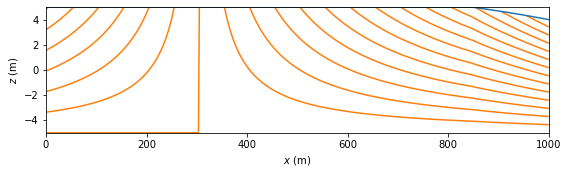

In [21]:
# basic streamline plot
plt.subplot(111, aspect=25)
plt.contour(xg, zg, psi, 20, colors='C1', linestyles='-')
plt.plot(xg[0], zg[1], 'C0')
plt.xlabel('$x$ (m)')
plt.ylabel('$z$ (m)');